In [1]:
include("../Engine/Engine.jl")
using .Engine

using StatsBase, DataFrames
using Graphs, SimpleWeightedGraphs
using DataStructures
import PyPlot as plt
import Seaborn as sns
import PlotlyJS

rcParams = plt.PyDict(plt.matplotlib."rcParams")
rcParams["text.usetex"] = false
rcParams["font.family"] = ["sans-serif"]
rcParams["font.serif"] = ["Computer Modern Roman"];

WebIO._IJuliaInit()

In [ ]:
function plot_betweenness_centrality2(influence_graphs::InfluenceGraphs, df::DataFrame, cuttoff::Real = 0.0; width=1., cut=0,
    save::Bool = false, filename = nothing, reorder = [2,3,1])

    if save && isnothing(filename)
        throw(ArgumentError("You must provide a filename if you want to save the figure."))
    end

    partitions, _, _ = partitions_actions_actors(df)

    # In this case remove default value
    if length(partitions) != 3 && reorder == [2,3,1]
        reorder = nothing
    end

    # Create simple graphs by removing weights not needed for the centrality
    simplifier = x -> maximum(x) > cuttoff
    simple_graphs = [SimpleDiGraph(simplifier.(graph)) for graph in influence_graphs]

    betweenness = [betweenness_centrality(graph, normalize=true) for graph in simple_graphs]

    if !isnothing(reorder)
        partitions = partitions[reorder]
        betweenness = betweenness[reorder]
    end

    plt.figure()
    sns.violinplot(betweenness, width=width, cut=cut)
    plt.xlabel("Partition")
    plt.ylabel("Betweenness centrality")
    ticks, _ = plt.xticks()
    plt.xticks(ticks, labels=partitions)
    plt.grid()
    if save
        mkpath(dirname(filename))
        plt.savefig(filename, bbox_inches="tight", dpi=400)
    end

    return plt.gcf()
end


function plot_outdegree_centrality2(influence_graphs::InfluenceGraphs, df::DataFrame, cuttoff::Real = 0.0; width=1., cut=0,
    save::Bool = false, filename = nothing, reorder = [2,3,1])

    if save && isnothing(filename)
        throw(ArgumentError("You must provide a filename if you want to save the figure."))
    end

    partitions, _, _ = partitions_actions_actors(df)

    # In this case remove default value
    if length(partitions) != 3 && reorder == [2,3,1]
        reorder = nothing
    end

    # Create simple graphs by removing weights not needed for the centrality
    simplifier = x -> maximum(x) > cuttoff
    simple_graphs = [SimpleDiGraph(simplifier.(graph)) for graph in influence_graphs]

    outdegrees = [outdegree(graph) for graph in simple_graphs]

    if !isnothing(reorder)
        partitions = partitions[reorder]
        outdegrees = outdegrees[reorder]
    end

    plt.figure()
    sns.violinplot(outdegrees, width=width, cut=cut)
    plt.xlabel("Partition")
    plt.ylabel("Outdegree centrality")
    ticks, _ = plt.xticks()
    plt.xticks(ticks, labels=partitions)
    plt.grid()
    if save
        mkpath(dirname(filename))
        plt.savefig(filename, bbox_inches="tight", dpi=400)
    end

    return plt.gcf()
end

In [2]:
graphs_JDD, cascades_JDD, df_JDD = load_data("/home/ubuntu/Thesis/Results/JDD_all_users/Skripal/data.jld2")

centrality_ranks_JDD = get_centrality_ranks(graphs_JDD, df_JDD, 0, "Any Edge")
all_centrality_ranks_JDD = get_centrality_ranks_all_edges(graphs_JDD, df_JDD, 0);

In [ ]:
plot_outdegree_centrality2(graphs_JDD, df_JDD)
plt.yscale("log")

In [3]:
graphs_TE, cascades_TE, df_TE = load_data("/home/ubuntu/Thesis/Results/TE_all_users/Skripal/data.jld2")

centrality_ranks_TE = get_centrality_ranks(graphs_TE, df_TE, 0, "Any Edge")
all_centrality_ranks_TE = get_centrality_ranks_all_edges(graphs_TE, df_TE, 0);

In [ ]:
# graphs_JDD, cascades_JDD, df_JDD = load_data("/home/ubuntu/Thesis/Results/JDD_all_users/Skripal_no_surro/data.jld2")

# centrality_ranks_JDD = get_centrality_ranks(graphs_JDD, df_JDD, 0, "Any Edge")
# all_centrality_ranks_JDD = get_centrality_ranks_all_edges(graphs_JDD, df_JDD, 0);

In [ ]:
# graphs_TE, cascades_TE, df_TE = load_data("/home/ubuntu/Thesis/Results/TE_all_users/Skripal_no_surro/data.jld2")

# centrality_ranks_TE = get_centrality_ranks(graphs_TE, df_TE, 0.04, "Any Edge")
# all_centrality_ranks_TE = get_centrality_ranks_all_edges(graphs_TE, df_TE, 0.04);

In [4]:
general_ranks = get_general_ranks(Skripal, skripal_dates);

In [ ]:
corr_JDD_TE = correlation_JDD_TE(all_centrality_ranks_JDD, all_centrality_ranks_TE, 50)
show(corr_JDD_TE, allcols=true)

# Table general

In [ ]:
general_ranking = find_max_ranks(general_ranks, 10)
print(latexify(general_ranking))

In [ ]:
show(general_ranking[3], allcols=true)

# Tables JDD

In [ ]:
centrality_ranking_JDD = find_max_ranks(centrality_ranks_JDD, 10)
print(latexify(centrality_ranking_JDD))

In [ ]:
show(centrality_ranking_JDD[1], allcols=true)

In [ ]:
df2_JDD = df_JDD[df_JDD.partition .== "During campaign", :]

centralities, actors = outdegree_centralities(graphs_JDD, df_JDD, edge_type="U to U")

outdegrees = centralities[3]
actors = actors[3]

indices = outdegrees .> 0
actors = actors[indices]
outdegrees = outdegrees[indices]

N_rt = zeros(length(outdegrees))
N_sp = zeros(length(outdegrees))

for (i, user) in enumerate(actors)
    domains = collect(Iterators.flatten(df2_JDD[df2_JDD.username .== user, "domain"]))
    count = countmap(domains)
    if "rt.com" in keys(count)
        N_rt[i] = count["rt.com"]
    end
    if "sputniknews.com" in keys(count)
        N_sp[i] = count["sputniknews.com"]
    end
end


# plt.figure()
# plt.scatter(outdegrees, N_rt)
# plt.xlabel("outdegree")
# plt.ylabel("Sharing of RT")
# plt.gcf()


# plt.figure()
# plt.scatter(outdegrees, N_sp)
# plt.xlabel("outdegree")
# plt.ylabel("Sharing of Sputnik")
# plt.gcf()


# plt.figure()
# plt.scatter(outdegrees, N_rt .+ N_sp)
# plt.xlabel("outdegree")
# plt.ylabel("Sharing of both")
# plt.gcf();

In [ ]:
df2_JDD = df_JDD[df_JDD.partition .== "During campaign", :]
df2_TE = df_TE[df_TE.partition .== "During campaign", :]

centralities_JDD, actors_JDD = outdegree_centralities(graphs_JDD, df_JDD, edge_type="U to U")
centralities_TE, actors_TE = outdegree_centralities(graphs_TE, df_TE, edge_type="U to U")

outdegrees_JDD = centralities_JDD[3]
actors_JDD = actors_JDD[3]
indices_JDD = outdegrees_JDD .> 0
actors_JDD = actors_JDD[indices]

outdegrees_TE = centralities_TE[3]
actors_TE = actors_TE[3]
actors_TE = actors_TE[1:length(actors_JDD)]

N_rt_JDD = zeros(length(actors_JDD))
N_sp_JDD = zeros(length(actors_JDD))

for (i, user) in enumerate(actors_JDD)
    domains = collect(Iterators.flatten(df2_JDD[df2_JDD.username .== user, "domain"]))
    count = countmap(domains)
    if "rt.com" in keys(count)
        N_rt_JDD[i] = count["rt.com"]
    end
    if "sputniknews.com" in keys(count)
        N_sp_JDD[i] = count["sputniknews.com"]
    end
end

N_rt_TE = zeros(length(actors_JDD))
N_sp_TE = zeros(length(actors_JDD))

for (i, user) in enumerate(actors_TE)
    domains = collect(Iterators.flatten(df2_TE[df2_TE.username .== user, "domain"]))
    count = countmap(domains)
    if "rt.com" in keys(count)
        N_rt_TE[i] = count["rt.com"]
    end
    if "sputniknews.com" in keys(count)
        N_sp_TE[i] = count["sputniknews.com"]
    end
end



plt.figure()
# plt.scatter(1:length(actors_JDD), N_rt_JDD, c="r", marker="+")
# plt.scatter(1:length(actors_JDD), N_rt_TE, c="b", marker="o")
sns.pointplot(x=1:length(actors_JDD), y=N_rt_JDD)
plt.xlabel("outdegree")
plt.ylabel("Sharing of RT")
plt.gcf();




In [ ]:
plt.scatter(1:10, 1:10, c="r", marker="+")
plt.scatter(1:10, 11:20, c="r", marker="+")

In [ ]:
df2_TE = df_TE[df_TE.partition .== "During campaign", :]

centralities, actors = outdegree_centralities(graphs_TE, df_TE, edge_type="U to U")

outdegrees = centralities[3]
actors = actors[3]

indices = outdegrees .> 0
actors = actors[indices]
outdegrees = outdegrees[indices]

N_rt = zeros(length(outdegrees))
N_sp = zeros(length(outdegrees))

for (i, user) in enumerate(actors)
    domains = collect(Iterators.flatten(df2_TE[df2_TE.username .== user, "domain"]))
    count = countmap(domains)
    if "rt.com" in keys(count)
        N_rt[i] = count["rt.com"]
    end
    if "sputniknews.com" in keys(count)
        N_sp[i] = count["sputniknews.com"]
    end
end


plt.figure()
plt.scatter(outdegrees, N_rt)
plt.xlabel("outdegree")
plt.ylabel("Sharing of RT")
plt.gcf()


plt.figure()
plt.scatter(outdegrees, N_sp)
plt.xlabel("outdegree")
plt.ylabel("Sharing of Sputnik")
plt.gcf()


plt.figure()
plt.scatter(outdegrees, N_rt .+ N_sp)
plt.xlabel("outdegree")
plt.ylabel("Sharing of both")
plt.gcf();

In [ ]:
df2_TE = df_TE[df_TE.partition .== "During campaign", :]

centralities, actors = betweenness_centralities(graphs_TE, df_TE, edge_type="U to U")

betweenness = centralities[3]
actors = actors[3]

indices = betweenness .> 0
actors = actors[indices][1:100]
betweenness = betweenness[indices][1:100]

N_rt = zeros(length(betweenness))
N_sp = zeros(length(betweenness))

for (i, user) in enumerate(actors)
    domains = collect(Iterators.flatten(df2_TE[df2_TE.username .== user, "domain"]))
    count = countmap(domains)
    if "rt.com" in keys(count)
        N_rt[i] = count["rt.com"]
    end
    if "sputniknews.com" in keys(count)
        N_sp[i] = count["sputniknews.com"]
    end
end


plt.figure()
plt.scatter(betweenness, N_rt)
plt.xlabel("betweenness")
plt.ylabel("Sharing of RT")
plt.gcf()


plt.figure()
plt.scatter(betweenness, N_sp)
plt.xlabel("betweenness")
plt.ylabel("Sharing of Sputnik")
plt.gcf()


plt.figure()
plt.scatter(betweenness, N_rt .+ N_sp)
plt.xlabel("betweenness")
plt.ylabel("Sharing of both")
plt.gcf();

In [ ]:
A = Dict("a" => 1, "b" => 2)
"n" in keys(A)

In [ ]:
outdegrees[1:12]

In [ ]:
df = centrality_ranking_JDD[1]
users = df.outdegree_rank

domains = []
for user in users
    push!(domains, collect(Iterators.flatten(df_JDD[df_JDD.username .== user, "domain"])))
end

In [ ]:
using StatsBase

user = "newsroll"
domains = collect(Iterators.flatten(df_JDD[df_JDD.username .== user, "domain"]))

foo = countmap(domains)
plt.figure()
plt.bar(1:length(foo), collect(values(foo)))
plt.xticks(1:length(foo), collect(keys(foo)), rotation="vertical");

In [ ]:
df[df.username .== "CraigMurrayOrg", :]

In [ ]:
df = load_dataset(Skripal)
retweets = df[df.effective_category .== "retweet", :]
retweets = skripal_dates(retweets)

df1 = retweets[retweets.partition .== "Before campaign", :]
df2 = retweets[retweets.partition .== "During campaign", :]
df3 = retweets[retweets.partition .== "After campaign", :]

t1 = combine(groupby(df1, "username"), "domain" => (x -> sum(in.(Ref("rt.com"), x))) => "rt_count")
t2 = combine(groupby(df1, "username"), "domain" => (x -> sum(in.(Ref("sputniknews.com"), x))) => "sp_count")
t3 = combine(groupby(df1, "username"), "domain" => (x -> sum(in.(Ref("rt.com"), x)) + sum(in.(Ref("sputniknews.com"), x))) => "sum")

test = t1

actors = unique(df_JDD.username)
indices = in.(test.username, Ref(actors))

test = test[indices, :]

test.sp_count = t2.sp_count[indices]
test.sum = t3.sum[indices]
sort!(test, :sum, rev=true)



In [ ]:
df1_JDD = df_JDD[df_JDD.partition .== "Before campaign", :]
df2_JDD = df_JDD[df_JDD.partition .== "During campaign", :]
df3_JDD = df_JDD[df_JDD.partition .== "After campaign", :]

test1 = combine(groupby(df2_JDD, "username"), "domain" => (x -> sum(in.(Ref("rt.com"), x))) => "rt_count")
test2 = combine(groupby(df2_JDD, "username"), "domain" => (x -> sum(in.(Ref("sputniknews.com"), x))) => "sp_count")
test3 = combine(groupby(df2_JDD, "username"), "domain" => (x -> sum(in.(Ref("rt.com"), x)) + sum(in.(Ref("sputniknews.com"), x))) => "sum")

test = test1
test.sp_count = test2.sp_count
test.sum = test3.sum
sort!(test, :sum, rev=true)

In [ ]:
sum(test.rt_count .> 10)

In [ ]:
a = [[1], [2,3], [4,5,6]]
collect(Iterators.flatten(a))

In [ ]:
all_centrality_ranking_JDD = find_max_ranks(all_centrality_ranks_JDD, 10)
print(latexify(all_centrality_ranking_JDD))

In [ ]:
show(all_centrality_ranking_JDD[3], allcols=true)

# Tables TE

In [ ]:
centrality_ranking_TE = find_max_ranks(centrality_ranks_TE, 10)
print(latexify(centrality_ranking_TE))

In [ ]:
show(centrality_ranking_TE[3], allcols=true)

In [ ]:
all_centrality_ranking_TE = find_max_ranks(all_centrality_ranks_TE, 10)
print(latexify(all_centrality_ranking_TE))

In [ ]:
show(all_centrality_ranking_TE[3], allcols=true)

In [ ]:
println(findfirst(ranking1.outdegree_rank .== "Ian56789"))
println(findfirst(ranking1.betweenness_rank .== "Ian56789"))

In [ ]:
general_ranks[1][general_ranks[1].username .== "Ian56789", :]

In [ ]:
rankingJDD = find_max_ranks(all_centrality_ranks_JDD, 15)
rankingTE = find_max_ranks(all_centrality_ranks_TE, 10);

In [ ]:
show(rankingJDD[1], allcols=true)

# Correlation matrices

┌ Warning: Partition Before campaign : tweet_rank or outdegree_rank has some missing values
└ @ Main.Engine.Metrics /home/ubuntu/Thesis/Julia/Utils/Metrics.jl:481
┌ Warning: Partition Before campaign : tweet_rank or betweenness_rank has some missing values
└ @ Main.Engine.Metrics /home/ubuntu/Thesis/Julia/Utils/Metrics.jl:481
┌ Warning: Partition Before campaign : follower_rank or outdegree_rank has some missing values
└ @ Main.Engine.Metrics /home/ubuntu/Thesis/Julia/Utils/Metrics.jl:481
┌ Warning: Partition Before campaign : follower_rank or betweenness_rank has some missing values
└ @ Main.Engine.Metrics /home/ubuntu/Thesis/Julia/Utils/Metrics.jl:481
┌ Warning: Partition Before campaign : retweet_rank or outdegree_rank has some missing values
└ @ Main.Engine.Metrics /home/ubuntu/Thesis/Julia/Utils/Metrics.jl:481
┌ Warning: Partition Before campaign : retweet_rank or betweenness_rank has some missing values
└ @ Main.Engine.Metrics /home/ubuntu/Thesis/Julia/Utils/Metrics.jl:481
┌ Warn

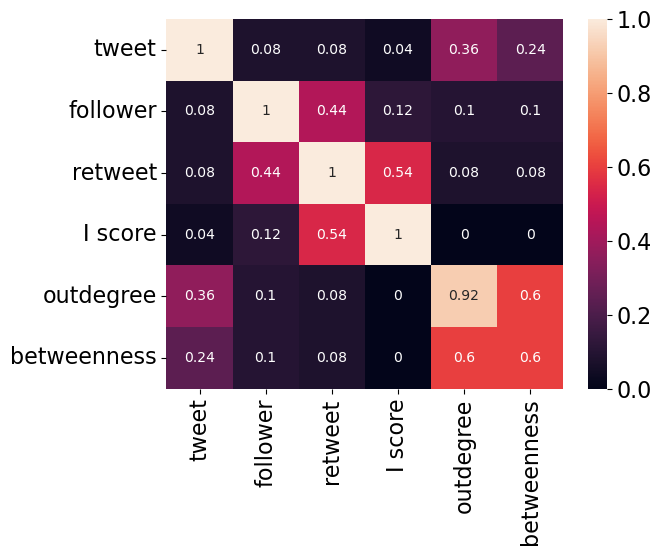

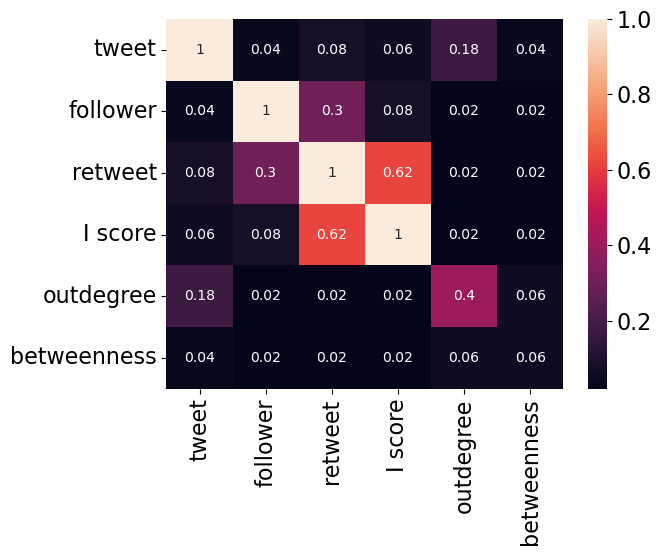

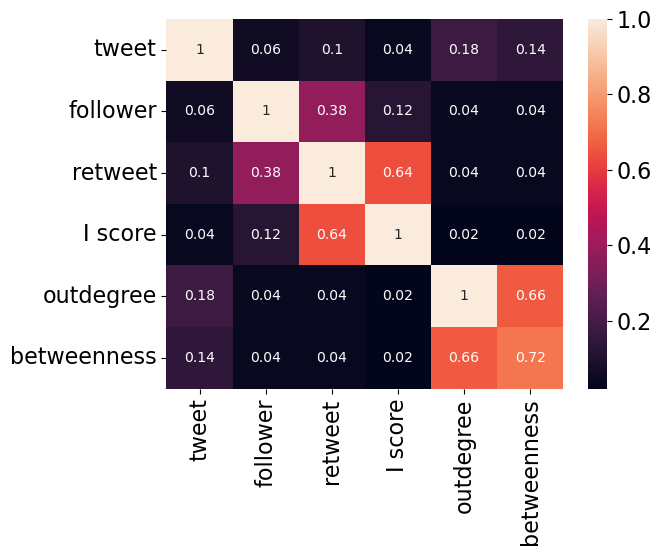

(Any[[1.0 0.08 … 0.36 0.24; 0.08 1.0 … 0.1 0.1; … ; 0.36 0.1 … 0.92 0.6; 0.24 0.1 … 0.6 0.6], [1.0 0.04 … 0.18 0.04; 0.04 1.0 … 0.02 0.02; … ; 0.18 0.02 … 0.4 0.06; 0.04 0.02 … 0.06 0.06], [1.0 0.06 … 0.18 0.14; 0.06 1.0 … 0.04 0.04; … ; 0.18 0.04 … 1.0 0.66; 0.14 0.04 … 0.66 0.72]], Any[SubString{String}["tweet", "follower", "retweet", "I score", "outdegree", "betweenness"], SubString{String}["tweet", "follower", "retweet", "I score", "outdegree", "betweenness"], SubString{String}["tweet", "follower", "retweet", "I score", "outdegree", "betweenness"]])

In [5]:
plot_correlation_matrices(general_ranks, centrality_ranks_JDD, 50, save=true, foldername="/home/ubuntu/Thesis/Figures/Skripal/JDD_all_users/")

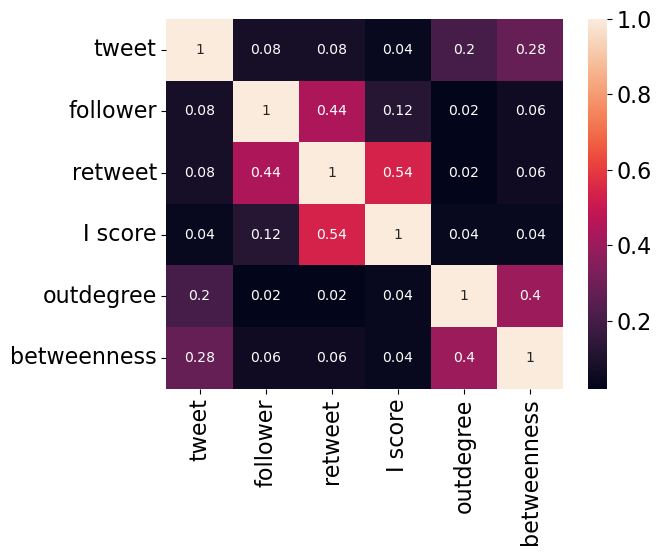

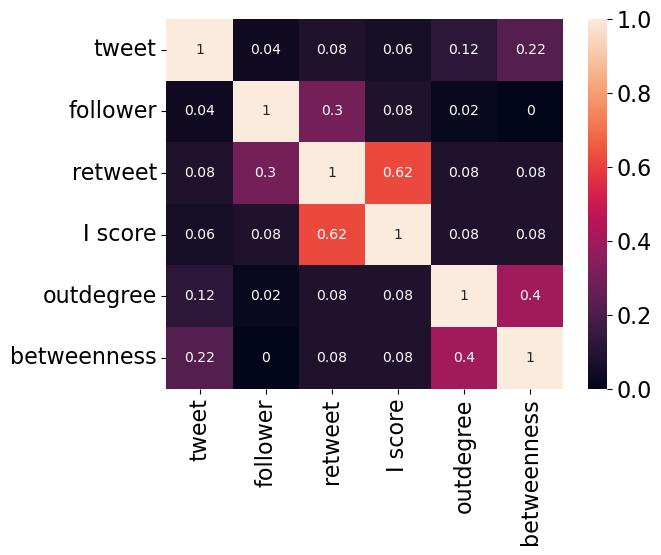

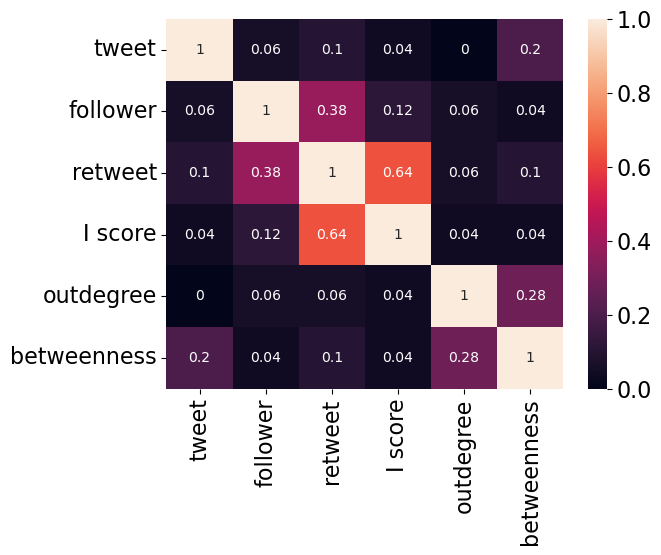

(Any[[1.0 0.08 … 0.2 0.28; 0.08 1.0 … 0.02 0.06; … ; 0.2 0.02 … 1.0 0.4; 0.28 0.06 … 0.4 1.0], [1.0 0.04 … 0.12 0.22; 0.04 1.0 … 0.02 0.0; … ; 0.12 0.02 … 1.0 0.4; 0.22 0.0 … 0.4 1.0], [1.0 0.06 … 0.0 0.2; 0.06 1.0 … 0.06 0.04; … ; 0.0 0.06 … 1.0 0.28; 0.2 0.04 … 0.28 1.0]], Any[SubString{String}["tweet", "follower", "retweet", "I score", "outdegree", "betweenness"], SubString{String}["tweet", "follower", "retweet", "I score", "outdegree", "betweenness"], SubString{String}["tweet", "follower", "retweet", "I score", "outdegree", "betweenness"]])

In [6]:
plot_correlation_matrices(general_ranks, centrality_ranks_TE, 50, save=true, foldername="/home/ubuntu/Thesis/Figures/Skripal/TE_all_users/")

# Edge types

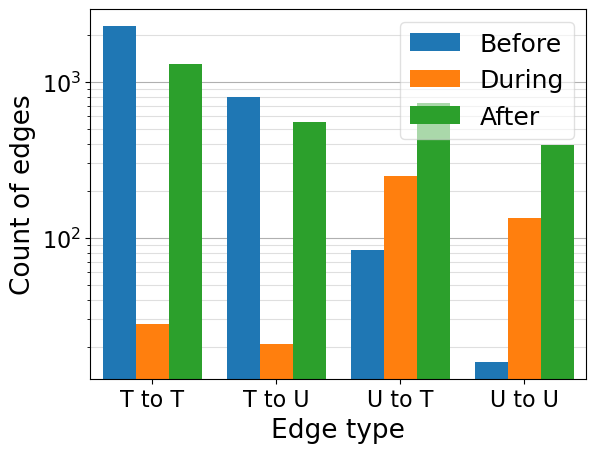

In [7]:
plot_edge_types(graphs_JDD, df_JDD, 0; y="count", hue_order=["Before", "During", "After"],
    save=true, filename="/home/ubuntu/Thesis/Figures/Skripal/JDD_all_users/edge_type_count.pdf", log=true);

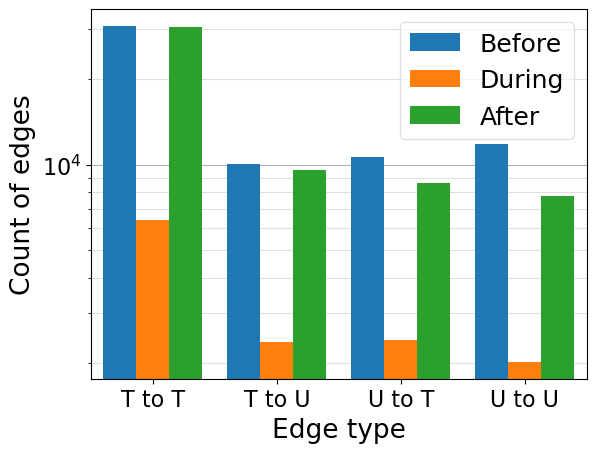

In [8]:
plot_edge_types(graphs_TE, df_TE, 0; y="count", hue_order=["Before", "During", "After"],
    save=true, filename="/home/ubuntu/Thesis/Figures/Skripal/TE_all_users/edge_type_count.pdf", log=true);

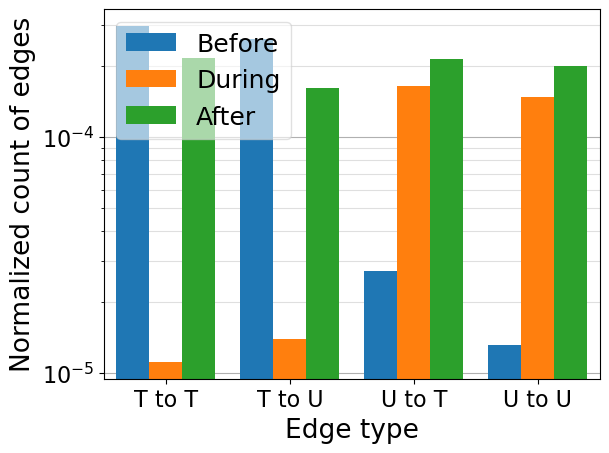

In [9]:
plot_edge_types(graphs_JDD, df_JDD, 0; y="count_normalized", hue_order=["Before", "During", "After"],
    save=true, filename="/home/ubuntu/Thesis/Figures/Skripal/JDD_all_users/edge_type.pdf", log=true);

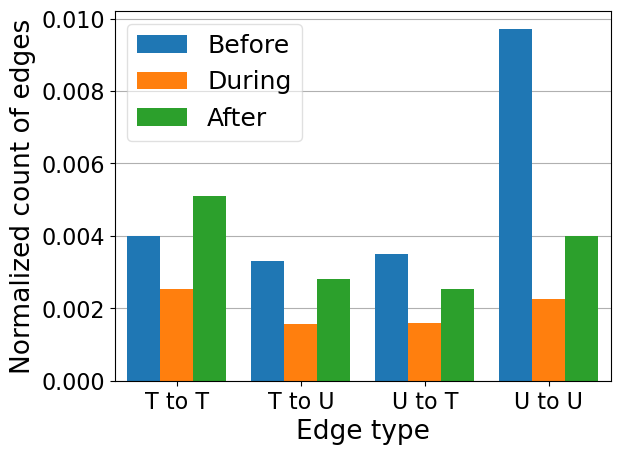

In [10]:
plot_edge_types(graphs_TE, df_TE, 0; y="count_normalized", hue_order=["Before", "During", "After"],
    save=true, filename="/home/ubuntu/Thesis/Figures/Skripal/TE_all_users/edge_type.pdf", log=false);

# Cascades reach

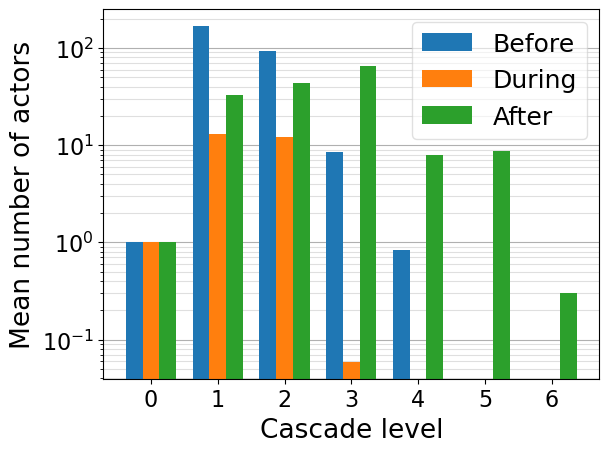

In [11]:
plot_actors_per_level(cascades_JDD, df_JDD, save=true, filename="/home/ubuntu/Thesis/Figures/Skripal/JDD_all_users/actor_level.pdf", inner_spacing=0);

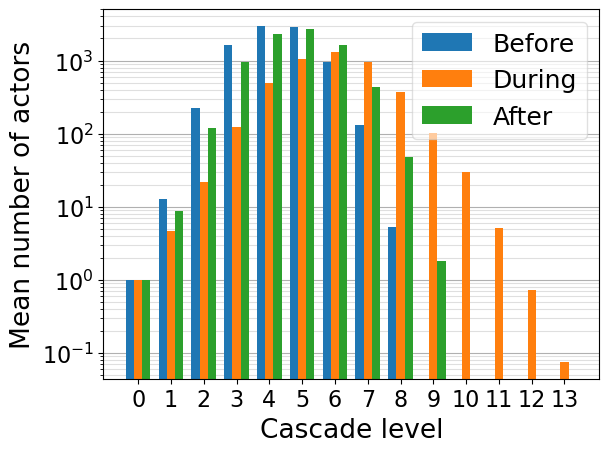

: 

In [12]:
plot_actors_per_level(cascades_TE, df_TE, save=true, filename="/home/ubuntu/Thesis/Figures/Skripal/TE_all_users/actor_level.pdf", inner_spacing=0);

# Cascades

In [ ]:
cascades[3]
PlotlyJS.plot(plot_cascade_sankey(cascades[3][6], df)...)
# PlotlyJS.savefig(PlotlyJS.plot(plot_cascade_sankey(cascades[3][5], df)...), "/home/ubuntu/Thesis/Figures/Skripal/TE_all_users/cascade.pdf")